# Sentinel-2 Image Visualization

Goal of the lecture:
1. Programmatically download a tile from the open and free [scihub.copernicus.eu](https://scihub.copernicus.eu/dhus/#/home) page
1. Extract indivdual bands and visualize them
1. Create an RGB image of three bands; one true-color and one false-color composite
1. Select a sub-region of the tile by defining a region of interest
1. Visualize the spectral signature of different land-use/land-cover classes

## Downloading the tile

Take a look at [scihub.copernicus.eu](https://scihub.copernicus.eu/dhus/#/home) to understand what we are tryig to accomplish with code!

To download a specific satellite tile, we have to:
1. Sign up for the service
1. Select a region of interest
1. Query Copernicus to select tiles from target satellite with relevant parameters



### Import Python libraries

If the libraries aren't available on paperspace, make the `ip4rs` IPython Kernel is selected in the top-right corner!

If it is not, change the kernel!

![](https://doc.cocalc.com/_images/jupyter-classic-change-kernel.png)

#### Notes for local installation
If you are on your local machine and the Python kernel suddenly dies, it probably means that you have installed incompatible binaries, please try install the dependencies by following the guide from [ip4rs-dependencies](https://github.com/kai-tub/ip4rs-dependencies).

In [57]:
import numpy as np
import geopandas
from pathlib import Path
import osmnx


from sentinelsat import SentinelAPI
from datetime import date
from shapely.geometry import Point
import rasterio
import zipfile

from enum import Enum
from typing import List, Sequence
import matplotlib.pyplot as plt

import rasterio.mask

### Set up credentials

In [58]:
# config set via DynaConf
# mainly for us to keep our secrets secret ;)
from dynaconf import Dynaconf

settings = Dynaconf(
    envvar_prefix="IP4RS",
    settings_files=["settings.toml", ".secrets.toml"],
)
###

SENTINEL_API_URL = "https://scihub.copernicus.eu/dhus"
YOUR_USERNAME = "kton"
YOUR_PWD = "12345678"
user = settings.get("scihub_copernicus_user", default=YOUR_USERNAME)
pwd = settings.get("scihub_copernicus_pwd", default=YOUR_PWD)

assert user != ""
assert pwd != ""

Let's select a point of interest (POI).
For this lab we will use the TU Berlin building.

The following code requires the Latitude and Longitude coordinates of the POI.
For now, we can simply rely on a service like [LatLong.net](latlong.net) to look up the coordinates:

- [TU Berlin coordinates via LatLong.net](https://www.latlong.net/place/technical-university-of-berlin-germany-248.html)

In [59]:
latitude = 52.512230
longitude = 13.327135

In [18]:
# geopandas.GeoSeries?

In [19]:
series = geopandas.GeoSeries([Point(longitude, latitude)], crs="EPSG:4326")
series

0    POINT (13.32714 52.51223)
dtype: geometry

In [20]:
# GeoPandas allows us to very quickly visually inspect our geographical data
series.explore(marker_type="marker")

In [21]:
api_sent = SentinelAPI(user, pwd, SENTINEL_API_URL)
# api_sent.query?

To query the copernicus database, we need to encode our geometry data into a common format that the service can understand.
Looking at the `SentinelAPI` documentation, we can see that the API expect the data to be encoded as a WKT string.

WKT stands for well-known text and is a simple text-based format to describe geometries. You can think of it as an [JSON](https://de.wikipedia.org/wiki/JavaScript_Object_Notation) alternative.

In [22]:
series.to_wkt()

0    POINT (13.327135 52.51223)
dtype: object

In [23]:
poi = series.to_wkt()[0]
poi

'POINT (13.327135 52.51223)'

In [60]:
start_date = date(year=2022, month=3, day=1)
end_date = date(year=2022, month=4, day=30)
satellite = "Sentinel-2"
producttype = "S2MSI2A"

products = api_sent.query(
    poi,
    date=(start_date, end_date),
    platformname=satellite,
    producttype=producttype,
    cloudcoverpercentage=(1, 20),
)

# convert to GeoPandas GeoDataFrame
products_gdf = api_sent.to_geodataframe(products)
assert not products_gdf.empty
products_gdf.head(1)
# If you get an internal-service error, simply try again

title  \
53f211a7-42d5-4a67-8fd6-69d70308a85a  S2B_MSIL2A_20220423T100549_N0400_R022_T33UUU_2...   

                                                                                   link  \
53f211a7-42d5-4a67-8fd6-69d70308a85a  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                       link_alternative  \
53f211a7-42d5-4a67-8fd6-69d70308a85a  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                              link_icon  \
53f211a7-42d5-4a67-8fd6-69d70308a85a  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                                summary  \
53f211a7-42d5-4a67-8fd6-69d70308a85a  Date: 2022-04-23T10:05:49.024Z, Instrument: MS...   

                                     ondemand      generationdate  \
53f211a7-42d5-4a67-8fd6-69d70308a85a    false 2022-04-23 13:43:29   

                                               beginposition  \
53f211a7-42d5-4a67-8fd6-69d70308a85a 2022-04-23 10:05:49.024   

                                                 endposition  \
53f211a7-42d5-4a67-8fd6-69d70308a85a 2022-04-23 10:05:49.024   

                                               ingestiondate  ...  \
53f211a7-42d5-4a67-8fd6-69d70308a85a 2022-04-23 17:46:09.092  ...   

                                      producttype  platformidentifier  \
53f211a7-42d5-4a67-8fd6-69d70308a85a      S2MSI2A           2017-013A   

                                      orbitdirection  \
53f211a7-42d5-4a67-8fd6-69d70308a85a      DESCENDING   

                                      platformserialidentifier  \
53f211a7-42d5-4a67-8fd6-69d70308a85a               Sentinel-2B   

                                      processinglevel  \
53f211a7-42d5-4a67-8fd6-69d70308a85a         Level-2A   

                                                                    datastripidentifier  \
53f211a7-42d5-4a67-8fd6-69d70308a85a  S2B_OPER_MSI_L2A_DS_VGS2_20220423T134329_S2022...   

                                                                      granuleidentifier  \
53f211a7-42d5-4a67-8fd6-69d70308a85a  S2B_OPER_MSI_L2A_TL_VGS2_20220423T134329_A0267...   

                                                                             identifier  \
53f211a7-42d5-4a67-8fd6-69d70308a85a  S2B_MSIL2A_20220423T100549_N0400_R022_T33UUU_2...   

                                                                      uuid  \
53f211a7-42d5-4a67-8fd6-69d70308a85a  53f211a7-42d5-4a67-8fd6-69d70308a85a   

                                                                               geometry  
53f211a7-42d5-4a67-8fd6-69d70308a85a  MULTIPOLYGON (((12.35500 52.23131, 13.67854 52...  

[1 rows x 41 columns]

In [25]:
# sort and select the first row
product = products_gdf.sort_values(
    ["cloudcoverpercentage", "ingestiondate"], ascending=[True, True]
).head(1)
product

title  \
6e5ad1c9-fc0e-4b93-9b5c-d0d401673206  S2A_MSIL2A_20220309T100841_N0400_R022_T32UQD_2...   

                                                                                   link  \
6e5ad1c9-fc0e-4b93-9b5c-d0d401673206  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                       link_alternative  \
6e5ad1c9-fc0e-4b93-9b5c-d0d401673206  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                              link_icon  \
6e5ad1c9-fc0e-4b93-9b5c-d0d401673206  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                                summary  \
6e5ad1c9-fc0e-4b93-9b5c-d0d401673206  Date: 2022-03-09T10:08:41.024Z, Instrument: MS...   

                                     ondemand      generationdate  \
6e5ad1c9-fc0e-4b93-9b5c-d0d401673206    false 2022-03-09 12:18:49   

                                               beginposition  \
6e5ad1c9-fc0e-4b93-9b5c-d0d401673206 2022-03-09 10:08:41.024   

                                                 endposition  \
6e5ad1c9-fc0e-4b93-9b5c-d0d401673206 2022-03-09 10:08:41.024   

                                               ingestiondate  ...  \
6e5ad1c9-fc0e-4b93-9b5c-d0d401673206 2022-03-09 17:48:53.772  ...   

                                      producttype  platformidentifier  \
6e5ad1c9-fc0e-4b93-9b5c-d0d401673206      S2MSI2A           2015-028A   

                                      orbitdirection  \
6e5ad1c9-fc0e-4b93-9b5c-d0d401673206      DESCENDING   

                                      platformserialidentifier  \
6e5ad1c9-fc0e-4b93-9b5c-d0d401673206               Sentinel-2A   

                                      processinglevel  \
6e5ad1c9-fc0e-4b93-9b5c-d0d401673206         Level-2A   

                                                                    datastripidentifier  \
6e5ad1c9-fc0e-4b93-9b5c-d0d401673206  S2A_OPER_MSI_L2A_DS_VGS4_20220309T121849_S2022...   

                                                                      granuleidentifier  \
6e5ad1c9-fc0e-4b93-9b5c-d0d401673206  S2A_OPER_MSI_L2A_TL_VGS4_20220309T121849_A0350...   

                                                                             identifier  \
6e5ad1c9-fc0e-4b93-9b5c-d0d401673206  S2A_MSIL2A_20220309T100841_N0400_R022_T32UQD_2...   

                                                                      uuid  \
6e5ad1c9-fc0e-4b93-9b5c-d0d401673206  6e5ad1c9-fc0e-4b93-9b5c-d0d401673206   

                                                                               geometry  
6e5ad1c9-fc0e-4b93-9b5c-d0d401673206  MULTIPOLYGON (((13.53103 52.17548, 13.63418 53...  

[1 rows x 41 columns]

In [26]:
# ensuring that the tile is the one we are also providing via a direct
# download link
assert product["title"][0] == "S2A_MSIL2A_20220309T100841_N0400_R022_T32UQD_20220309T121849"

In [27]:
# Would fail, because there are entries that cannot be JSON encoded!
# product.explore()
# Only visualize the relevant columns and convert them if necessary
product[["title", "summary", "geometry"]].explore()

### Download the tile

In [28]:
product

title  \
6e5ad1c9-fc0e-4b93-9b5c-d0d401673206  S2A_MSIL2A_20220309T100841_N0400_R022_T32UQD_2...   

                                                                                   link  \
6e5ad1c9-fc0e-4b93-9b5c-d0d401673206  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                       link_alternative  \
6e5ad1c9-fc0e-4b93-9b5c-d0d401673206  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                              link_icon  \
6e5ad1c9-fc0e-4b93-9b5c-d0d401673206  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                                summary  \
6e5ad1c9-fc0e-4b93-9b5c-d0d401673206  Date: 2022-03-09T10:08:41.024Z, Instrument: MS...   

                                     ondemand      generationdate  \
6e5ad1c9-fc0e-4b93-9b5c-d0d401673206    false 2022-03-09 12:18:49   

                                               beginposition  \
6e5ad1c9-fc0e-4b93-9b5c-d0d401673206 2022-03-09 10:08:41.024   

                                                 endposition  \
6e5ad1c9-fc0e-4b93-9b5c-d0d401673206 2022-03-09 10:08:41.024   

                                               ingestiondate  ...  \
6e5ad1c9-fc0e-4b93-9b5c-d0d401673206 2022-03-09 17:48:53.772  ...   

                                      producttype  platformidentifier  \
6e5ad1c9-fc0e-4b93-9b5c-d0d401673206      S2MSI2A           2015-028A   

                                      orbitdirection  \
6e5ad1c9-fc0e-4b93-9b5c-d0d401673206      DESCENDING   

                                      platformserialidentifier  \
6e5ad1c9-fc0e-4b93-9b5c-d0d401673206               Sentinel-2A   

                                      processinglevel  \
6e5ad1c9-fc0e-4b93-9b5c-d0d401673206         Level-2A   

                                                                    datastripidentifier  \
6e5ad1c9-fc0e-4b93-9b5c-d0d401673206  S2A_OPER_MSI_L2A_DS_VGS4_20220309T121849_S2022...   

                                                                      granuleidentifier  \
6e5ad1c9-fc0e-4b93-9b5c-d0d401673206  S2A_OPER_MSI_L2A_TL_VGS4_20220309T121849_A0350...   

                                                                             identifier  \
6e5ad1c9-fc0e-4b93-9b5c-d0d401673206  S2A_MSIL2A_20220309T100841_N0400_R022_T32UQD_2...   

                                                                      uuid  \
6e5ad1c9-fc0e-4b93-9b5c-d0d401673206  6e5ad1c9-fc0e-4b93-9b5c-d0d401673206   

                                                                               geometry  
6e5ad1c9-fc0e-4b93-9b5c-d0d401673206  MULTIPOLYGON (((13.53103 52.17548, 13.63418 53...  

[1 rows x 41 columns]

In [29]:
download_dir = Path("./data")
download_dir.mkdir(exist_ok=True)

# ~800MB large!
# May take a while to download
# The download is very slow from their server

# output_file = download_dir / f"{product.title[0]}.zip"
# if not output_file.exists():
#     api_sent.download_all(product.index, directory_path=download_dir)

In [32]:
# local convenience function
# from downloader import download
from simple_downloader import download

TUB_URL = "https://tubcloud.tu-berlin.de/s/QSi8fHG9ffG5FKE/download/S2A_MSIL2A_20220309T100841_N0400_R022_T32UQD_20220309T121849.zip"
output_file = download(TUB_URL, "./data/")

Target file already exists!
Will skip download. To force download set `force=True`


### Extract zipfile

In [31]:
zipf = zipfile.ZipFile(output_file)
zipf.extractall(path="data")

The data inside of the Zip-file is packaged into a "root" directory with the name of the original zip file + the `.SAFE` extension.
The data we are interested in lives inside a subdirectory called `IMG_DATA`.
The image data is encoded as a [jpeg2000](https://de.wikipedia.org/wiki/JPEG_2000) file with the extension `jp2`.

We can combine all of the information to build a [glob](https://en.wikipedia.org/wiki/Glob_(programming)) expression to quickly build a list of the files we are interested in.

Note: The directory structure has been changed very recently, depending on the selected dates, the relevant images live either directly under the `IMG_DATA` directory, or they live under a sub-directory `IMG_DATA/R{10,20,60}m/`.

In [35]:
unzipped_dir = output_file.with_suffix(".SAFE")
assert unzipped_dir.exists()

## Working with the tile data
### Accessing the data array

In [36]:
class Band(str, Enum):
    """A collection of different Sentinel-2 band names."""

    B01 = "B01"
    B02 = "B02"
    B03 = "B03"
    B04 = "B04"
    B05 = "B05"
    B06 = "B06"
    B07 = "B07"
    B08 = "B08"
    B8A = "B8A"
    B09 = "B09"
    B10 = "B10"
    B11 = "B11"
    B12 = "B12"

    def __str__(self):
        return self.value


def read_s2_jp2_data(jp2_data_path: Path) -> np.ndarray:
    """
    Read band from Sentinel-2 jp2 file.
    """
    with rasterio.open(jp2_data_path) as data:
        # rasterio is 1-indexed
        return data.read(1)


def _get_all_jp2_files(source_dir: Path, parent_dir: str = "IMG_DATA/R60m") -> List[Path]:
    """
    Given a Sentinel-2 source directory, find all jp2 files that have
    a parent folder named `parent_dir`.
    Usually, it should be the folder `IMG_DATA`, other possible source
    would be the quality masks in `QI_DATA`.
    To not load band multiple times at different resolutions, by default
    the lowest 60m band is loaded.

    Note: Depending on the acquisition date and data type, the structure might be different
    and no sub-directory within `IMG_DATA` exists!
    """
    image_files = list(source_dir.glob(f"**/{parent_dir}/*.jp2"))
    assert len(image_files) > 0
    return image_files


class S2_TileReader:
    def __init__(self, safe_directory: Path, img_data_parent_dir: str = "IMG_DATA/R60m"):
        self.image_files = _get_all_jp2_files(safe_directory, parent_dir=img_data_parent_dir)

    def _get_band_path(self, band: Band) -> Path:
        return [f for f in self.image_files if f"_{band}_" in f.name][0]

    def read_band_data(self, band: Band) -> np.ndarray:
        band_path = self._get_band_path(band)
        return read_s2_jp2_data(band_path)


s2_reader = S2_TileReader(unzipped_dir)
band03_data = s2_reader.read_band_data(Band.B03)

### Visualizing tiles
#### Visualizing individual channels

Sentinel-2 satellite data is encoded in an uncommon format `uint16` and requires special care, when trying to visualize.
The minimum and maximum values are given by physical properties of the sensor and are not normalize to fill the entire data range.

In [37]:
band03_data.min(), band03_data.max(), band03_data.shape, band03_data.dtype

(0, 6624, (1830, 1830), dtype('uint16'))

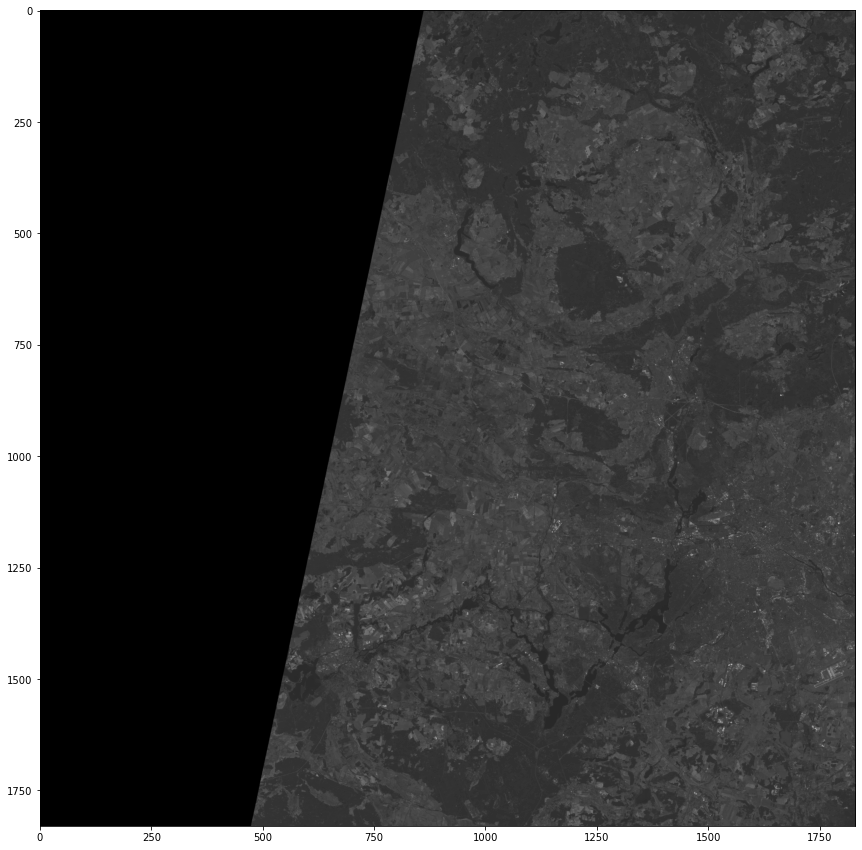

In [38]:
plt.figure(figsize=(15, 15))
plt.imshow(band03_data, cmap="gray")

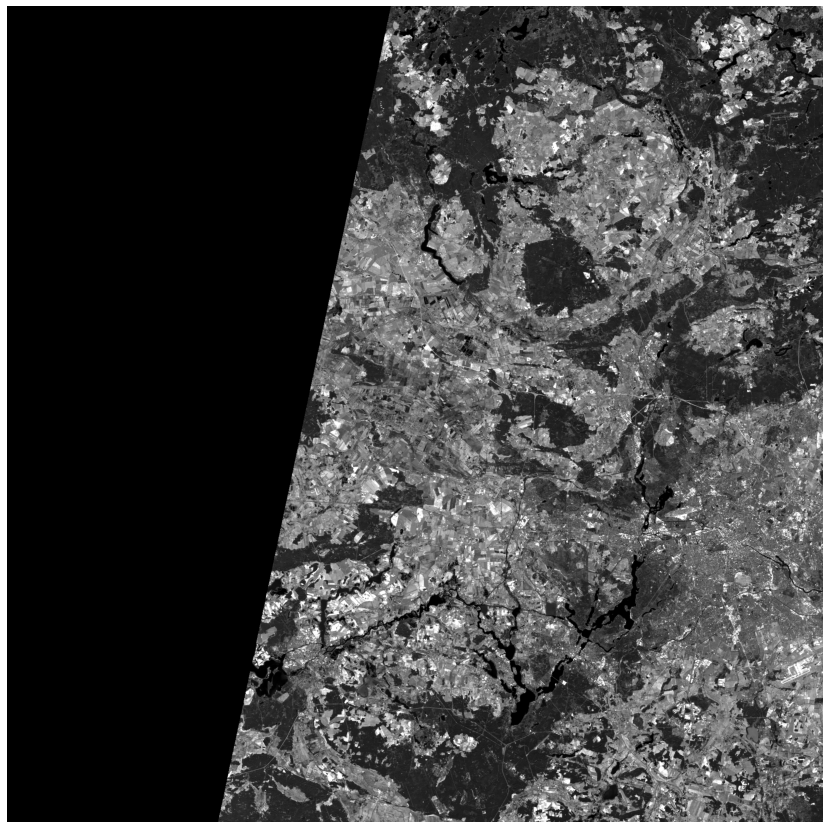

In [39]:
def quant_norm_data(
    data: np.ndarray, lower_quant: float = 0.01, upper_quant: float = 0.99
) -> np.ndarray:
    """
    Normalize the data by quantiles `lower_quant/upper_quant`.
    The quantiles are calculated globally/*across all channels*.
    """
    masked_data = np.ma.masked_equal(data, 0)
    lq, uq = np.quantile(masked_data.compressed(), (lower_quant, upper_quant))
    data = np.clip(data, a_min=lq, a_max=uq)
    data = (data - lq) / (uq - lq)
    return data


def vis(data: np.ndarray, quant_norm: bool = True):
    """
    Visualize an array by calling `imshow` with `cmap="gray"`.
    By default, the image is normalized through `quant_norm_data`.
    """
    if quant_norm:
        data = quant_norm_data(data)

    plt.figure(figsize=(15, 15))
    plt.axis("off")
    plt.imshow(data, cmap="gray")


vis(band03_data)

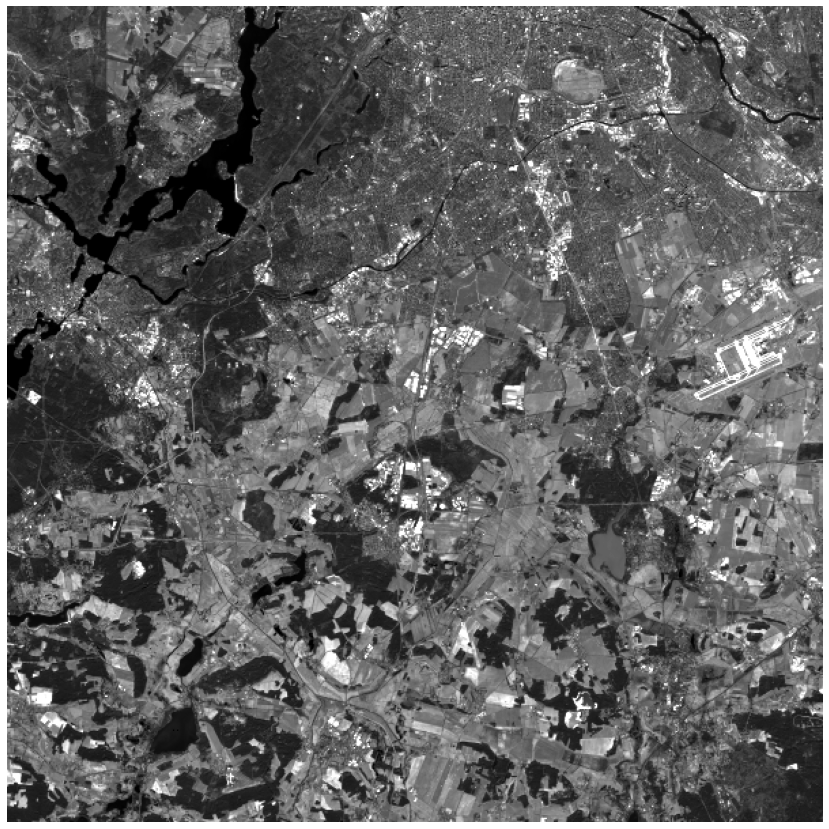

In [40]:
# vis(band03_data)
sub_band03_data = band03_data[-600:, -600:]
vis(sub_band03_data)

#### Visualizing multiple bands

In [42]:
rgb_arr = np.stack(
    [s2_reader.read_band_data(b) for b in (Band.B04, Band.B03, Band.B02)],
    axis=-1,
)
rgb_arr.shape

(1830, 1830, 3)

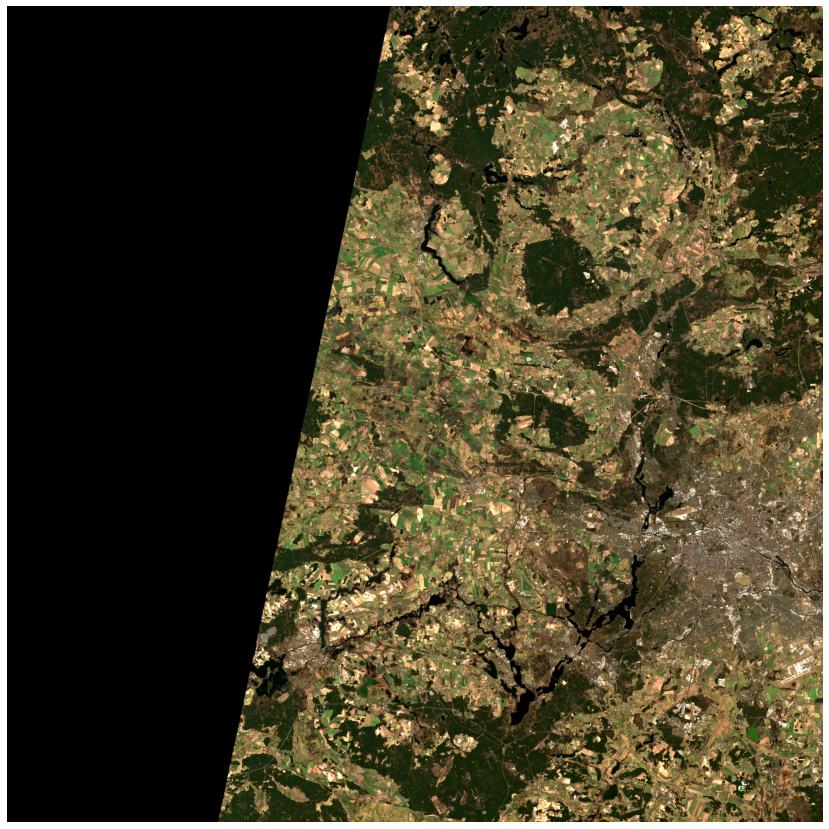

In [48]:
vis(rgb_arr)

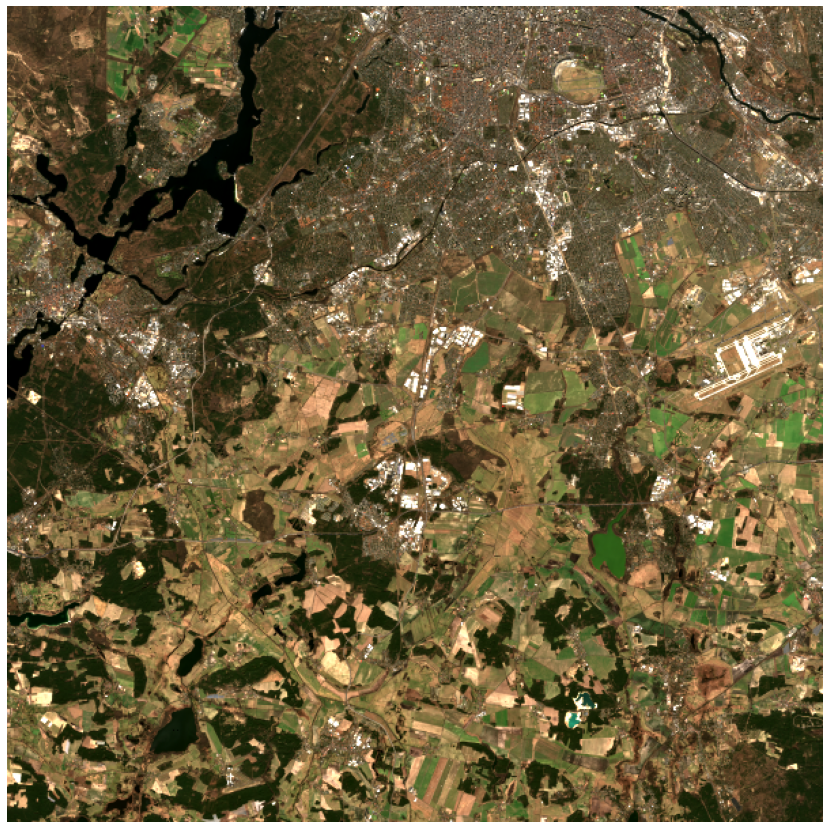

In [49]:
sub_rgb_arr = rgb_arr[-600:, -600:]
vis(sub_rgb_arr)

In [50]:
# store each channel individually with a key to
# make it easier to work with it later
np.savez(
    "data/sub_rgb_arr",
    red=sub_rgb_arr[:, :, 0],
    green=sub_rgb_arr[:, :, 1],
    blue=sub_rgb_arr[:, :, 2],
)
np.savez("data/rgb_arr", red=rgb_arr[:, :, 0], green=rgb_arr[:, :, 1], blue=rgb_arr[:, :, 2])

#### Exercise

Create a False Color Composite by visualizing the bands `B8A`, `B04`, `B03`.

### Selecting regions of tiles

Use the `osmnx` library to retrieve the area of interest by looking up a name-identifier.

In [51]:
berlin_gdf = osmnx.geocode_to_gdf("Berlin")
berlin_gdf

/opt/conda/envs/ip4rs/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


geometry  bbox_north  bbox_south  \
0  MULTIPOLYGON (((13.08835 52.41963, 13.09021 52...   52.675509   52.338245   

   bbox_east  bbox_west   place_id  osm_type  osm_id        lat        lon  \
0  13.761161  13.088345  282238400  relation   62422  52.506935  13.397483   

      display_name     class            type  importance  
0  Berlin, Germany  boundary  administrative    0.897539

In [52]:
berlin_gdf.explore()

In [53]:
def read_s2_jp2_data_with_clipping(
    band_data_path: Path, clip_geoseries: geopandas.GeoSeries, envelope: bool = True
) -> np.ndarray:
    with rasterio.open(band_data_path) as data:
        # ensure that the data is using the same coordinate reference system
        reprojected_geoseries = clip_geoseries.to_crs(data.crs)
        reprojected_geoseries = (
            reprojected_geoseries.envelope if envelope else reprojected_geoseries
        )
        out_img, _out_transform = rasterio.mask.mask(data, reprojected_geoseries, crop=True)
        # drop singleton axes
        out_img = out_img.squeeze()
    return out_img

In [54]:
class S2_TileReader:
    def __init__(self, safe_directory: Path, img_data_parent_dir: str = "IMG_DATA/R60m"):
        self.image_files = _get_all_jp2_files(safe_directory, parent_dir=img_data_parent_dir)

    def _get_band_path(self, band: Band) -> Path:
        return [f for f in self.image_files if f"_{band}_" in f.name][0]

    def read_band_data(self, band: Band) -> np.ndarray:
        band_path = self._get_band_path(band)
        return read_s2_jp2_data(band_path)

    def read_band_data_with_clipping(
        self, band: Band, clip_geoseries: geopandas.GeoSeries, envelope: bool = True
    ) -> np.ndarray:
        band_path = self._get_band_path(band)
        return read_s2_jp2_data_with_clipping(band_path, clip_geoseries, envelope=envelope)


# re-initialize
s2_reader = S2_TileReader(unzipped_dir)
clipped_band03_data = s2_reader.read_band_data_with_clipping(
    Band.B03, berlin_gdf.geometry, envelope=True
)

In [55]:
# berlin_gdf.envelope.explore()

In [ ]:
vis(clipped_band03_data)

In [ ]:
clipped_rgb_arr = np.stack(
    [s2_reader.read_band_data_with_clipping(b, berlin_gdf.geometry) for b in ("B04", "B03", "B02")],
    axis=-1,
)

In [ ]:
vis(clipped_rgb_arr)

In [ ]:
vis(clipped_rgb_arr)

## Inspecting spectral signature

In [ ]:
# LCLU: Land-Cover Land-Use
lclu_gdf = geopandas.GeoDataFrame(
    {"type": ["water", "airport", "forest"]},
    geometry=[
        Point(13.175955, 52.456009),
        Point(13.508517, 52.380236),
        Point(13.212926, 52.478834),
    ],
    crs="epsg:4326",
)
lclu_gdf.reset_index().explore(marker_type="marker")

In [ ]:
# depends on product type and used image directory!
AVAILABLE_BANDS = (
    Band.B01,
    Band.B02,
    Band.B03,
    Band.B04,
    Band.B05,
    Band.B06,
    Band.B07,
    Band.B8A,
    Band.B09,
    Band.B11,
    Band.B12,
)


def read_points_from_tile(
    s2_reader: S2_TileReader,
    points_series: geopandas.GeoSeries,
    bands: Sequence[Band] = AVAILABLE_BANDS,
) -> np.ndarray:
    if set(lclu_gdf.geom_type) != {"Point"}:
        raise ValueError("Only point geometries are allowed!")

    return np.array([s2_reader.read_band_data_with_clipping(b, points_series) for b in bands])

In [ ]:
lclu_gdf

In [ ]:
water_spectral_sig = read_points_from_tile(s2_reader, lclu_gdf.query("type == 'water'"))
airport_spectral_sig = read_points_from_tile(
    s2_reader, lclu_gdf.query("type == 'airport'").geometry
)
forest_spectral_sig = read_points_from_tile(s2_reader, lclu_gdf.query("type == 'forest'").geometry)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(AVAILABLE_BANDS, forest_spectral_sig, "o-", label="forest", linewidth=2)
plt.plot(AVAILABLE_BANDS, airport_spectral_sig, "o-", label="airport", linewidth=2)
plt.plot(AVAILABLE_BANDS, water_spectral_sig, "o-", label="water", linewidth=2)

plt.legend(fontsize=14)
plt.grid()

### In-course Practice:

Select 3 different point (pixels) and plot their spectral signitures